In [1]:
# Подключение к Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/GU_neural_network/'

In [0]:
import sys
sys.path.append(PATH)

In [4]:
!pip install keras

## Практическое задание

<ol>
    <li>Попробуйте изменить параметры нейронной сети работающей с датасетом imdb так, чтобы улучшить ее точность. Приложите анализ.<br><br>
    </li> 
    
</ol>

##Константы

In [0]:
NUM_WORDS = 10000
RANDOM_STATE = 1
SKIP_TOP = 0
MAX_LEN = 200

## Библотеки

In [6]:
import numpy as np
import keras
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM
from keras import regularizers
import pickle

import warnings
warnings.filterwarnings(action='ignore', category=Warning)

Using TensorFlow backend.


In [0]:
np.random.seed(RANDOM_STATE)

## Подготовка данных

In [0]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz", 
                                                      num_words = NUM_WORDS, 
                                                      skip_top=SKIP_TOP, 
                                                      seed=RANDOM_STATE,
                                                      oov_char=2)

In [9]:
x_train.shape, x_test.shape

((25000,), (25000,))

In [0]:
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

## Дополнительные функции

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  fig = plt.figure()
  fig.set_size_inches(15, 15)

  ax_1 = fig.add_subplot(2, 2, 1)
  ax_2 = fig.add_subplot(2, 2, 2)
  ax_3 = fig.add_subplot(2, 2, 3)
  ax_4 = fig.add_subplot(2, 2, 4)


  for key in history.keys():
    ax_1.plot(history[key].history['accuracy'], label=key)
    ax_2.plot(history[key].history['val_accuracy'], label=key)
    ax_3.plot(history[key].history['loss'], label=key)
    ax_4.plot(history[key].history['val_loss'], label=key)

  ax_1.set(title = 'Model accuracy on train data', label='Accuracy', xlabel='Epoch')
  ax_1.legend(loc='lower right')
  ax_2.set(title = 'Model accuracy on test data', label='Accuracy', xlabel='Epoch')
  ax_2.legend(loc='lower right')
  ax_3.set(title = 'Model loss on train data', label='loss', xlabel='Epoch')
  ax_3.legend(loc='upper right')
  ax_4.set(title = 'Model loss on test data', label='loss', xlabel='Epoch')
  ax_4.legend(loc='upper right')

  plt.show()

## 1. Обучение нейронной сети работающей с датасетом imdb

In [0]:
def baseline_model(name='baseline', vocab_size=NUM_WORDS, l1=0.01):
  # Build the model.
  size = 8
  model = Sequential(name=name)
  
  model.add(Embedding(input_dim=vocab_size, output_dim=size))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(size , activation='tanh', kernel_regularizer=regularizers.l1(l1)))
  model.add(Dense(1, activation='tanh'))


  # Compile the model
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

In [0]:
def lstm_model(name='lstm', max_features=NUM_WORDS):
    # Build the model.
  size = 128
  model = Sequential(name=name)
  
  model.add(Embedding(max_features, size))
  model.add(LSTM(size, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))


  # Compile the model
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

In [0]:
def modify_lstm_model(name='modify', max_features=NUM_WORDS, l2=0.01):
    # Build the model.
  size = 64
  model = Sequential(name=name)
  
  model.add(Embedding(input_dim=max_features, output_dim=size))
  model.add(LSTM(size, activation='relu' , recurrent_regularizer=regularizers.l2(l2),  kernel_regularizer=regularizers.l2(l2))) # 
  model.add(Dense(1, activation='sigmoid'))


  # Compile the model
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

In [0]:
FULL_ROAD=True
history_file = 'history.pickle'
EPOCHES = 30

In [0]:
if FULL_ROAD:
  models = []
  models.append(baseline_model())
  models.append(lstm_model())
  models.append(modify_lstm_model(l2=0.07))
  history = {}
else:
  models = []
  models.append(modify_lstm_model(l2=0.07))
  with open(history_file, 'rb') as handle:
    history = pickle.load(handle)

In [17]:

i = 0
batch_size = 1000

for model in models:
  i+= 1
  print(f'{i}. {model.name}  ')
  %time history[model.name] = model.fit(x=x_train, y=y_train,\
                      batch_size=batch_size,\
                      epochs=EPOCHES,\
                      verbose=0, \
                      validation_data=(x_test, y_test))
  
  loss, accuracy = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
  print(f'Accuracy: {accuracy}  ')
  print(f'Binary_crossentropy: {loss}  ')
  model.summary()

1. baseline  
CPU times: user 6.45 s, sys: 802 ms, total: 7.25 s
Wall time: 6.01 s
25000/25000 [==============================] - 0s 2us/step
Accuracy: 0.8148400187492371  
Binary_crossentropy: 0.6861939477920532  
Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 80,081
Trainable params: 80,081
Non-trainable params: 0
_________________________________________________________________
2. lstm  
CPU times: user 6min 59s, s

## 2. Анализ

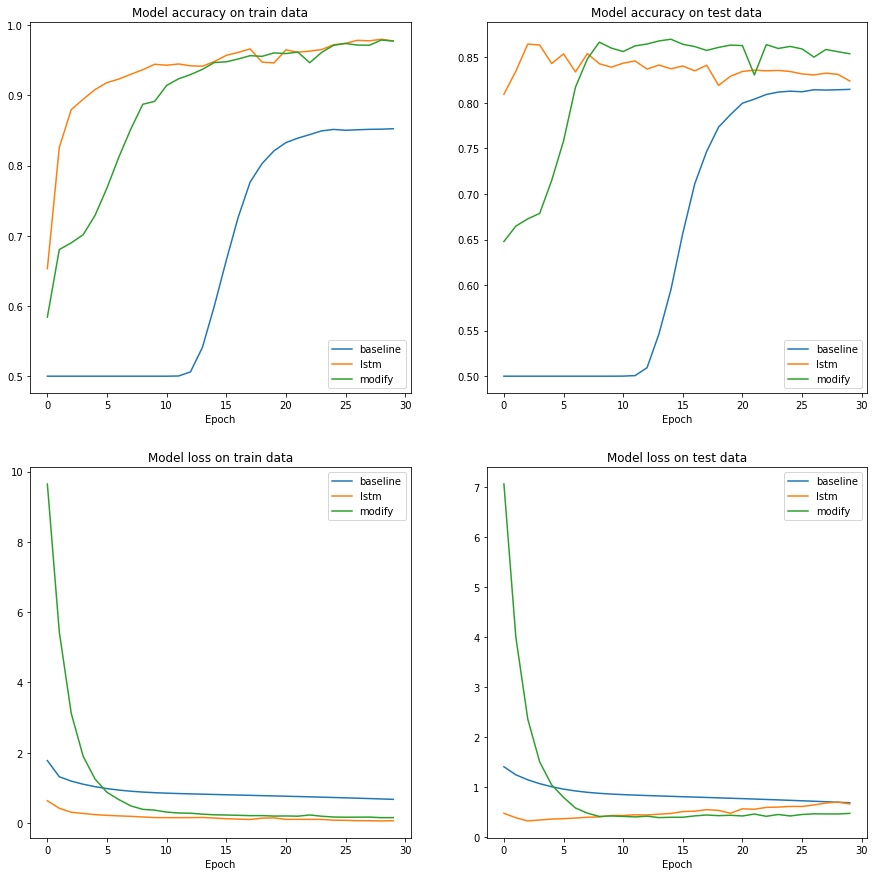

In [18]:
select_list = ['baseline', 'lstm', 'modify']
filter_history = {k: v for k, v in history.items() if k in select_list}
plot_history(filter_history )

In [0]:
with open(history_file, 'wb') as handle:
  pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)

##Вывод:
Уменьшив количество нейронов в слое и добавив регуляризацию, удалось снизить объем и время обучения, улучшив незначитльено основные метрики.